## Cleaning FERC 1 Fuel data
This notebook is meant to help get you understand the data cleaning process for FERC Form 1 fuel data for heat content and price per MMBTU data.

In [4]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..')))
from pudl import pudl, ferc1, eia923, settings, constants
from pudl import models, models_ferc1, models_eia923
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
pudl_engine = pudl.db_connect_pudl()

## Define a function to clean data frames: What kind of errors are we fixing? Why is this kind of function a reasonable thing to do?
Looking at some of the distributions of the data below, it becomes clear immediately that there are the data was originally entered in a variety of ways. 

Data has been entered in the different units, for example coal heat content values are entered in mmbtu per pound for some records while for most records it is entered in mmbtu per ton. Similarly we see data entered in different orders of magnitude, like gas heat content values entered in mmbtu per cubic foot rather than in mmbtu per thousand cubic foot.

Since these data entry differences are separated by two or more orders of magnitude, we can often clearly delineate between populations. We can identify the primary distribution of values by looking at alternative sources, like the EIA, for the same data set and looking at physical properties of the fuels. For example, the average heat content of a ton of U.S. coal is roughly 20 mmbtu. We can identify the end points of the primary distrubtion in other data sources and apply that range of values to the FERC data to identify the primary distribtuion in the FERC data.

Since data outside of the primary distribution is in most cases easily distinguishable and off by a an order of magnitude (e.g. 2000 for heat content per pound rather than per ton) we can with reasonable confidence use a small set of multipliers to bring outlying populations of data into the primary distribtuion, correcting for errors in how the data was entered.

First let's pull in the applicable data from the PUDL FERC tables:

In [9]:
fuel_df = pd.read_sql('''SELECT * from fuel_ferc1''',pudl_engine)
coal = fuel_df[fuel_df.fuel=='coal']
gas = fuel_df[fuel_df.fuel=='gas']

Then, we'll define a function that takes as arguments: 

- a data series to be cleaned
- minimum and maximum values bounding the reasonable range of values for the series
- multipliers (a list) to the minimum and maximum values are divided to define additional ranges of data, which are brought into the reasonable range by multiplying the values in the additional ranges by the multipliers (e.g. if a set of values is 1000 times too large to fit in the reasonable range, its multiplier will be .001).

The function will return a cleaned series.

In [14]:
def fixit(tofix, min, max, mults):
    
    fixed = tofix.copy()
    fixed = fixed[fixed > 0]
    for mult in mults:
        fixed = fixed.apply(lambda x: x*mult if x > min/mult and x < max/mult else x)
    fixed = fixed.apply(lambda x: np.nan if x < min or x > max else x)
    return(fixed)

We'll next define a function to show us graphs of what the data looks like before and after it is cleaned, and to show us how much data the cleaning process was not able to clean. This function will take 5 arguments:

- a series of data to be cleaned
- a series of data which has been cleaned by the cleaning function
- the title (string) to apply to the before and after graphs
- the x label (string) to apply to the before and after graphs
- the y label (string) to apply to the before and after graphs

The function will returned the before and after graphs and the percentage of how many values were not cleaned and were instead set to NaN.

Our showfix function first displays unaltered populations on a log-log scale for two reasons. These populations are separated by orders of magnitude and it would be difficult to show them on the same graph otherwise. These populations are also often vastly different sizes: when one population is has thousands of occurences and the other tens, one is not able to see both without a logarthmic scale.

The showfix function then displays the data once multipliers have been applied to the populations. This population necessarily lies in the same order of magnitude so a linear x axis scale makes sense for view. It's more intuitive for most to view the frequency of occurences on a linear scale as well so a linear y axis is used as well. 

In [15]:
def showfix(tofix,fixed,title,xlabel,ylabel):
    
    min_1 = tofix[tofix > 0].min()
    max_1 = tofix.max()
    fraction_lost =  ( fixed.isnull().sum() / len(fixed) ) * 100
    show_fraction = 'The percentage of values set to NaN is {} %'\
    .format(round(fraction_lost,2))
    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 14,
        }
    
    fig_1 = plt.figure(figsize=(16,12))
    plt.subplot(2,1,1)
    plt.title(title)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid()
    ax = fig_1.axes[0]
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.xlim(min_1,max_1)
    plt.hist(tofix, bins=np.logspace(np.log10(min_1), np.log10(max_1), 100))
    
    plt.subplot(2,1,2)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid()
    plt.hist(fixed.dropna(),bins=100)
    plt.text(0, .05, show_fraction, transform=fig_1.transFigure,fontdict=font)
    plt.show()

We'll define a simple graphing function to help us make the graph and a flexible graphing function to help us make slightly more complex graphs later on.

In [16]:
def simplegraph(series,xlabel,ylabel,title,range1,range2):
    plt.figure(figsize=(10,7))
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title)
    plt.hist(series,bins=100,range=(range1,range2))
    plt.show()

In [17]:
def flexiblegraph(series,xlabel,ylabel,title,yscale,range1,range2,bins):
    plt.figure(figsize=(10,7))
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title)
    plt.yscale(yscale)
    plt.hist(series,bins=bins,range=(range1,range2))
    plt.show()

## FERC Cost per unit delivered
### FERC Coal cost per unit delivered
Let's take a look at histograms of FERC Form 1 cost per unit delivered for coal. Nearly all of the fuel units are in tons.

In [179]:
coal.fuel_unit.value_counts()

ton      2958
mmbtu       7
mcf         2
bbl         1
Name: fuel_unit, dtype: int64

We'll start by dropping values below zero.

In [10]:
ferc_coal_cost_delivered = coal[coal.fuel_cost_per_unit_delivered > 0]
ferc_gas_cost_delivered = gas[gas.fuel_cost_per_unit_delivered > 0]

The EIA reports that the "average annual sale prices of coal at mines producing each of the four major ranks of coal in 2015, in dollars per short ton (2,000 pounds)were: Bituminous—51.57, Subbituminous—14.63, Lignite—22.36, Anthracite—97.91..." (https://www.eia.gov/energyexplained/index.cfm?page=coal_prices).

"In 2015, the average sales price of coal at the mine was 31.83 per ton, and the average delivered coal price to the electric power sector was 42.58 per ton, resulting in an average transportation cost of 10.75 per ton, or about 25 percent of the total delivered price."

Looking at EIA data for average coal cost by state from 2008 through 2016, one sees a range from 14 dollars to 190 (for coal shipped to Maine in 2012!) dollars per ton (https://drive.google.com/open?id=0B5TMZz2CEFSbcjc5RmVSQUR4LXc). Let's use these bounds to identify the primary distribution for FERC coal cost per unit delivered.

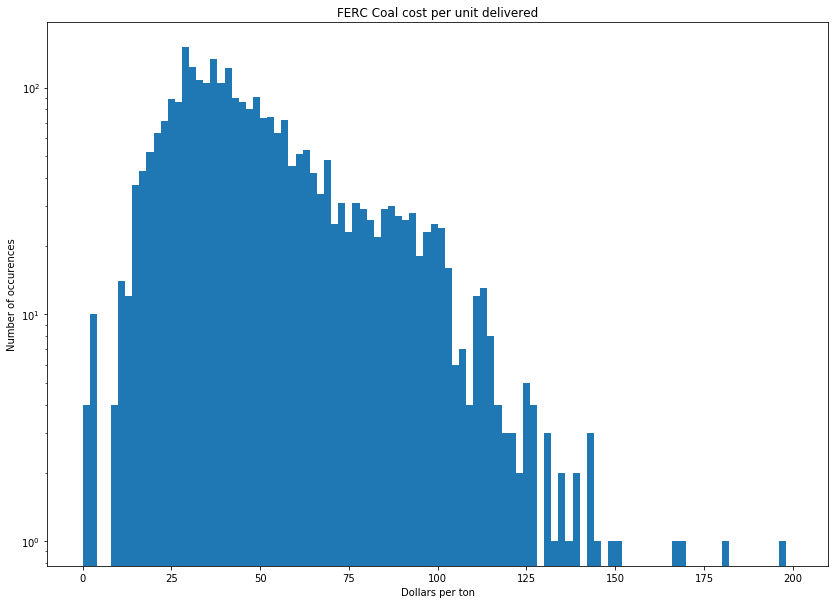

In [186]:
plt.figure(figsize=(14,10))
plt.hist(ferc_coal_cost_delivered.fuel_cost_per_unit_delivered, bins=100,log=True,range=(0,200))
plt.title('FERC Coal cost per unit delivered')
plt.xlabel('Dollars per ton')
plt.ylabel('Number of occurences')
plt.show()

There are only a handful of values near zero. It appears that these utilities entered the cost per mmbtu rather than the cost per ton. While some have listed mmbtu as the fuel unit, others have not. We could multiply these by the corrected average heat content per unit to get the price per ton but since it's a small population we will not worry about it for now.

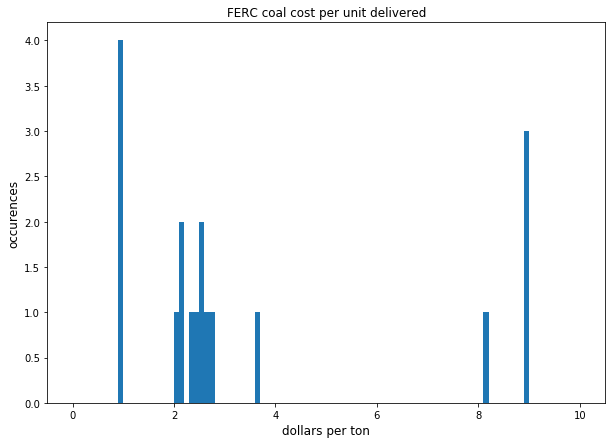

In [174]:
simplegraph(ferc_coal_cost_delivered.fuel_cost_per_unit_delivered,'dollars per ton',\
           'occurences','FERC coal cost per unit delivered',0,10)

In [177]:
ferc_coal_cost_delivered[ferc_coal_cost_delivered.fuel_cost_per_unit_delivered < 10]

,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
651,652,62,Scherer,2007,coal,mmbtu,16661466.0,0.011963,2.020,2.048,2.011,2052.0,10.206
1228,1229,12,Osage,2007,coal,ton,240865.0,0.007906,8.920,8.920,1.000,16.0,16.299
1229,1230,12,Neil Simpson Complex,2007,coal,ton,642797.0,0.007985,9.810,8.910,0.610,8.0,12.452
1231,1232,12,Wyodak - Bhp 20% She,2007,coal,ton,410016.0,0.007831,9.270,8.920,0.590,6780.0,11.452
2145,2146,62,Scherer,2008,coal,mmbtu,13018186.0,0.011945,2.083,2.173,2.094,2161.0,10.535
4007,4008,62,Scherer,2009,coal,mmbtu,1471202.0,0.011955,2.133,2.130,2.112,2127.0,10.073
5521,5522,62,Scherer,2010,coal,ton,12786515.0,0.011949,2.240,2.379,2.279,2330.0,10.230
6244,6245,403,Wygen Ii,2011,coal,ton,519300.0,0.007862,15.590,0.960,1.030,13.0,12.106
6273,6274,12,Wygen Iii,2011,coal,ton,596017.0,0.007854,8.750,8.170,0.000,12.0,13.397
6923,6924,62,Scherer,2011,coal,ton,15945277.0,0.011958,2.432,2.433,2.403,2520.0,10.496


There are only 4 values above 200. There doesn't appear to be a common theme unifying these records.

In [187]:
ferc_coal_cost_delivered[ferc_coal_cost_delivered.fuel_cost_per_unit_delivered > 200]

,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
4193,4194,122,Colstrip 4,2010,coal,ton,1138599.0,0.008430,44033.320,44033.320,0.948,10.0,10.941253
7616,7617,17,H.B. Robinson,2012,coal,ton,98417.0,0.011877,137.522,222.696,5.790,65.0,10.932000
8148,8149,57,Mitchell,2012,coal,ton,1545.0,0.000000,433.265,433.265,17.280,-325.0,-18.832766
8160,8161,57,Mcintosh,2012,coal,ton,839.0,0.000000,266.219,266.219,0.000,-17.0,0.000000


Weighting the cost per unit delivered shows us a more confined range of values. Still, values range out to nearly 200 but the distribution shows two sharper peaks near 30 dollars per ton. Since we don't have quantity delivered values, we weight the cost delivered data by quantity burned.

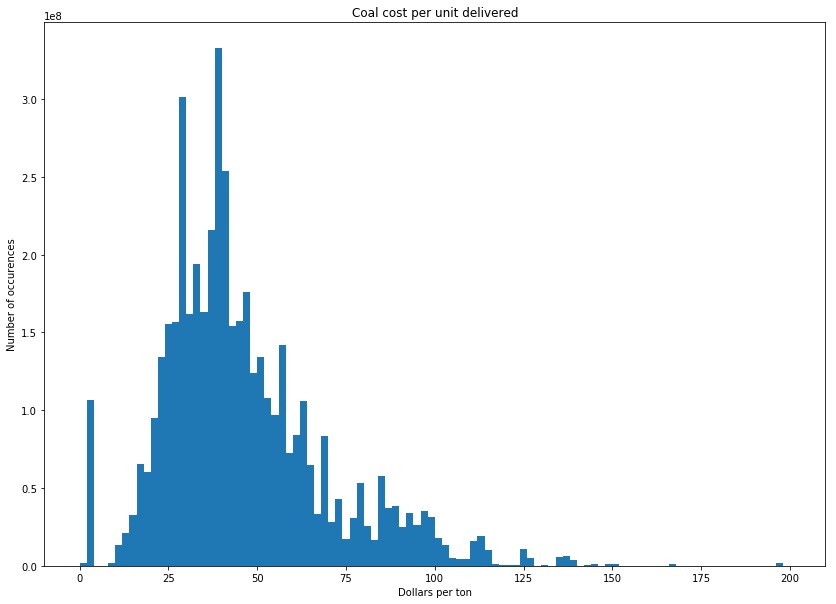

In [189]:
plt.figure(figsize=(14,10))
plt.hist(ferc_coal_cost_delivered.fuel_cost_per_unit_delivered,\
         weights=ferc_coal_cost_delivered.fuel_qty_burned, bins=100,range=(0,200))
plt.title('Coal cost per unit delivered')
plt.xlabel('Dollars per ton')
plt.ylabel('Number of occurences')
plt.show()

Let's use the cleaning functions to limit the data to the EIA state average values with a minimum of 14 and a maximum of 190.

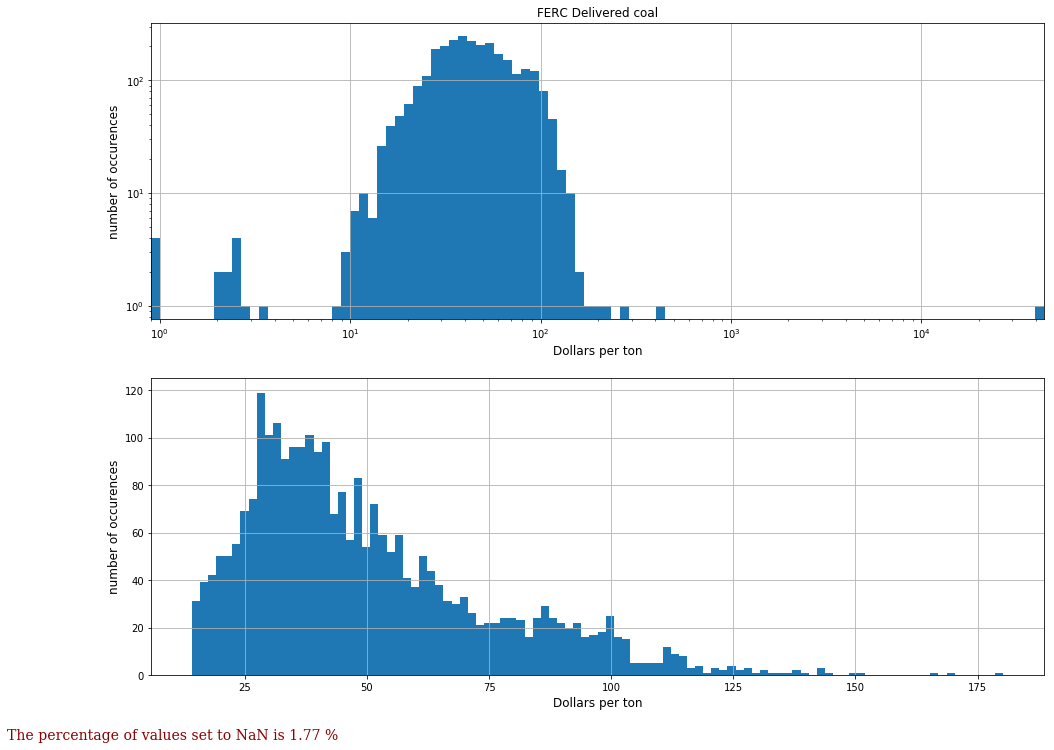

In [263]:
ferc_delivered_coal = fixit(ferc_coal_cost_delivered.fuel_cost_per_unit_delivered, 14, 190, [1])
showfix(ferc_coal_cost_delivered.fuel_cost_per_unit_delivered,ferc_delivered_coal,'FERC Delivered coal',\
       'Dollars per ton','number of occurences')

### FERC Gas cost per unit delivered

Given that there's roughly 1 mmbtu per mcf of natural gas (on average 1.032 mmbtu according to EIA (https://www.eia.gov/tools/faqs/faq.php?id=45&t=8), the distribution for gas costs delivered should be very similar to that of the cost per mmbtu. The bounds for dollars per mmbtu from EIA data were from 1 to 35 dollars so the bounds for mcf delivered should be very similar, if only slightly higher. Let's start with the graphing the primary distribution.

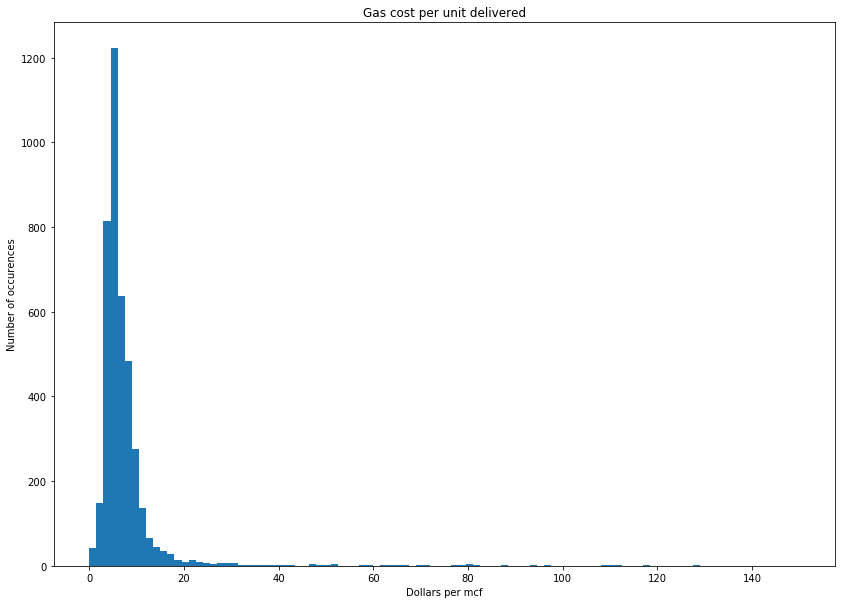

In [197]:
plt.figure(figsize=(14,10))
plt.hist(ferc_gas_cost_delivered.fuel_cost_per_unit_delivered, bins=100,range=(0,150))
plt.title('Gas cost per unit delivered')
plt.xlabel('Dollars per mcf')
plt.ylabel('Number of occurences')
plt.show()

It looks like there are two tiny outlying populations - one that's 100 times too big and one that's 100 times too small. Some of the records in the population that's 100 times too big appear to be related to a dollars and cents issue - however it is only  few records and the population appears overlaps with the primary distribution. Given the overlap, we won't include these values. Both populations are less than a percentage point.

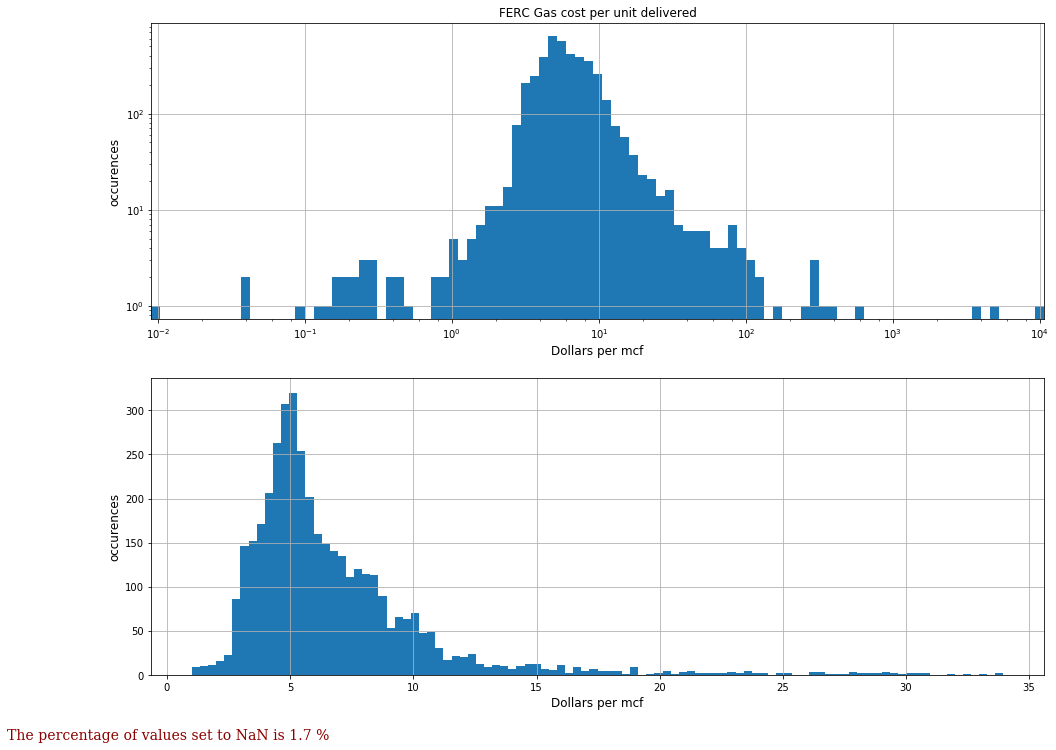

In [18]:
ferc_delivered_gas = fixit(ferc_gas_cost_delivered.fuel_cost_per_unit_delivered, 1, 35, [100])
showfix(ferc_gas_cost_delivered.fuel_cost_per_unit_delivered,ferc_delivered_gas,'FERC Gas cost per unit delivered',\
       'Dollars per mcf','occurences')

Looking at the smaller of the two populations, it does not appear to mirror the main population and it's not clear what would make the population 100 times too small.

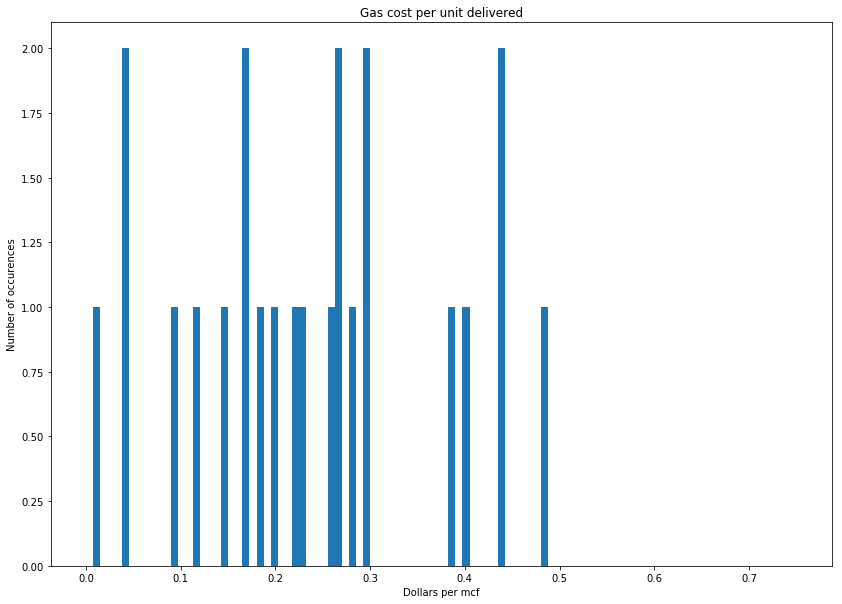

In [222]:
plt.figure(figsize=(14,10))
plt.hist(ferc_gas_cost_delivered.fuel_cost_per_unit_delivered, bins=100,range=(0,.75))
plt.title('Gas cost per unit delivered')
plt.xlabel('Dollars per mcf')
plt.ylabel('Number of occurences')
plt.show()

In [219]:
ferc_gas_cost_delivered[(ferc_gas_cost_delivered.fuel_cost_per_unit_delivered > 0) & (ferc_gas_cost_delivered.fuel_cost_per_unit_delivered > 1)]

,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
1,2,186,Altavista,2007,gas,mcf,24908.0,0.001040,11.090,12.140,14.090,0.0,0.000000
3,4,186,Bellemeade,2007,gas,mcf,3415467.0,0.001029,8.157,8.690,14.010,80.0,9.374000
13,14,186,Darbytown,2007,gas,mcf,1423188.0,0.001027,7.864,7.840,7.660,97.0,12.523000
15,16,186,Gordonsville,2007,gas,mcf,3381835.0,0.001041,8.305,8.690,12.420,69.0,8.330000
17,18,186,Gravel Neck,2007,gas,mcf,861042.0,0.001040,7.807,7.730,7.510,94.0,12.414000
19,20,186,Ladysmith,2007,gas,mcf,1962619.0,0.001027,8.361,8.360,8.140,90.0,10.849000
27,28,186,North Branch,2007,gas,bbl,263946.0,0.091800,63.590,65.990,16.340,0.0,0.000000
30,31,186,Possum Point,2007,gas,mcf,2912413.0,0.001045,6.230,8.020,5.970,75.0,0.000000
31,32,186,Remington,2007,gas,mcf,1602849.0,0.001041,9.130,8.970,8.780,95.0,10.780000
39,40,186,Possum Point Com Cyc,2007,gas,mcf,15793061.0,0.001046,8.356,8.020,8.010,61.0,0.000000


There are only a handful of values above 100. It appears that some but not all of these are off by a factor of 100 because the utility entered cents rather than dollars.

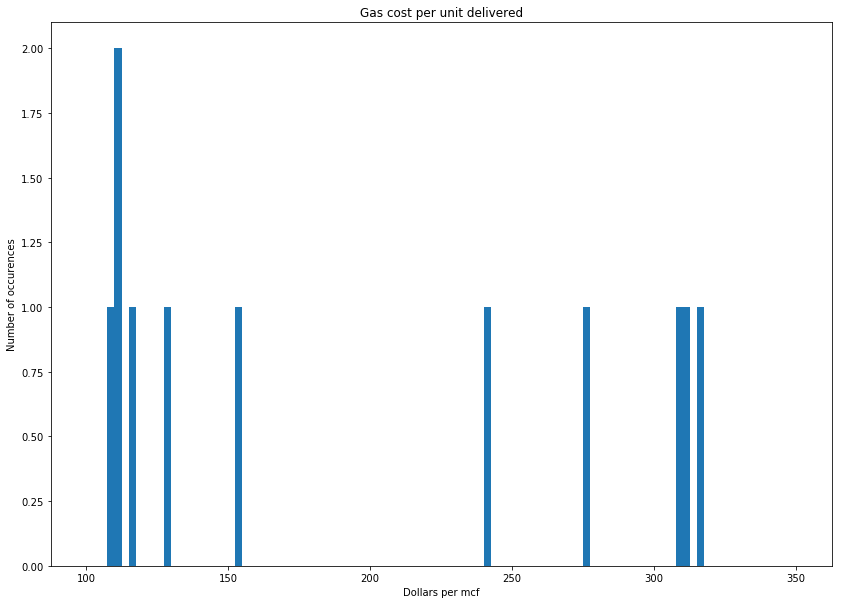

In [221]:
plt.figure(figsize=(14,10))
plt.hist(ferc_gas_cost_delivered.fuel_cost_per_unit_delivered, bins=100,range=(100,350))
plt.title('Gas cost per unit delivered')
plt.xlabel('Dollars per mcf')
plt.ylabel('Number of occurences')
plt.show()

In [211]:
ferc_gas_cost_delivered[ferc_gas_cost_delivered.fuel_cost_per_unit_delivered > 100]

,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
1427,1428,122,Huron Gt,2008,gas,mmbtu,3386.0,0.001000,10490.000,10490.000,3.552,-296.0,-0.028217
2247,2248,195,Plant Total-Weston,2008,gas,mcf,308175.0,0.001005,10.900,117.270,10.834,106.0,0.000000
2306,2307,193,Germantown-Total,2008,gas,mcf,5436.0,0.001010,371.822,371.822,876.527,13000.0,0.000000
3416,3417,89,M34/Marinette,2009,gas,mcf,2960.0,0.001004,110.997,110.997,110.586,1460.0,13.204000
3708,3709,193,Germantown-Total,2009,gas,mcf,1645.0,0.001010,276.945,276.945,652.872,14889.0,0.000000
4812,4813,176,Sundt,2010,gas,mcf,17780.0,0.001020,315.681,315.681,309.491,4930.0,15.929000
4913,4914,151,Allegany Station 133,2010,gas,mcf,344735.0,0.001027,5.658,4946.000,6.054,55.0,7.552899
5077,5078,45,Riverbend,2010,gas,mcf,13.0,1.017000,561.308,561.308,561.308,0.0,0.000000
5828,5829,19,West Coxsackie,2011,gas,mcf,14224.0,0.001027,10670.000,10670.000,10386.000,156.0,15.000000
9257,9258,42,Conesville,2013,gas,bbl,183.0,0.136781,128.474,127.709,22.364,0.0,0.000000


Since we don't have quantity delivered values, we weight the graph above by quantity burned. This distribution also appears to fit nicely with the EIA 923 bounds of 1 and 35.

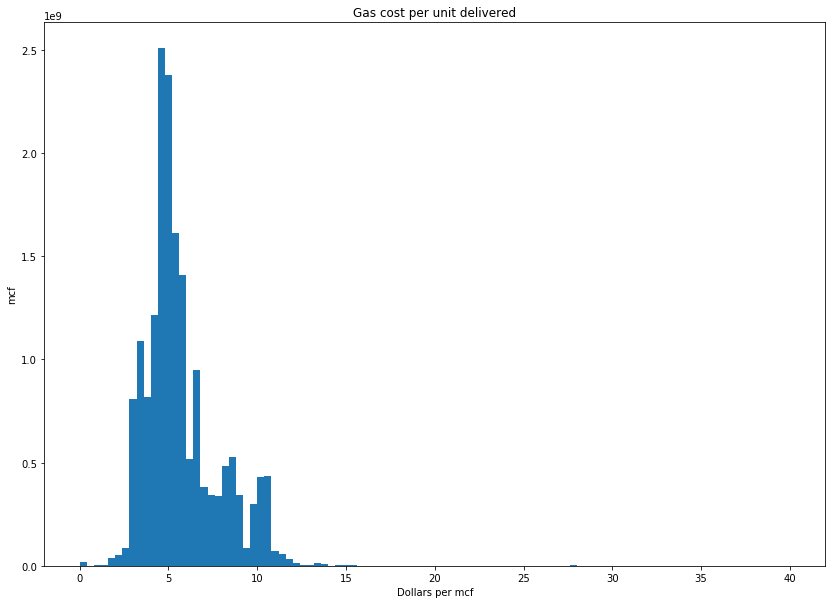

In [240]:
plt.figure(figsize=(14,10))
plt.hist(ferc_gas_cost_delivered.fuel_cost_per_unit_delivered,\
         weights=ferc_gas_cost_delivered.fuel_qty_burned,bins=100,range=(0,40))
plt.title('Gas cost per unit delivered')
plt.xlabel('Dollars per mcf')
plt.ylabel('mcf')
plt.show()

## FERC Cost per unit burned
### FERC Coal cost per unit burned
Let's take a look at histograms for FERC cost per unit burned for coal. We can rely on the same range of values used for the cost of fuel delivered. We expect that the values will be very similar to the results for cost per unit delivered.

In [251]:
ferc_coal_cost_burned = coal[coal.fuel_cost_per_unit_burned > 0]
ferc_gas_cost_burned = gas[gas.fuel_cost_per_unit_burned > 0]

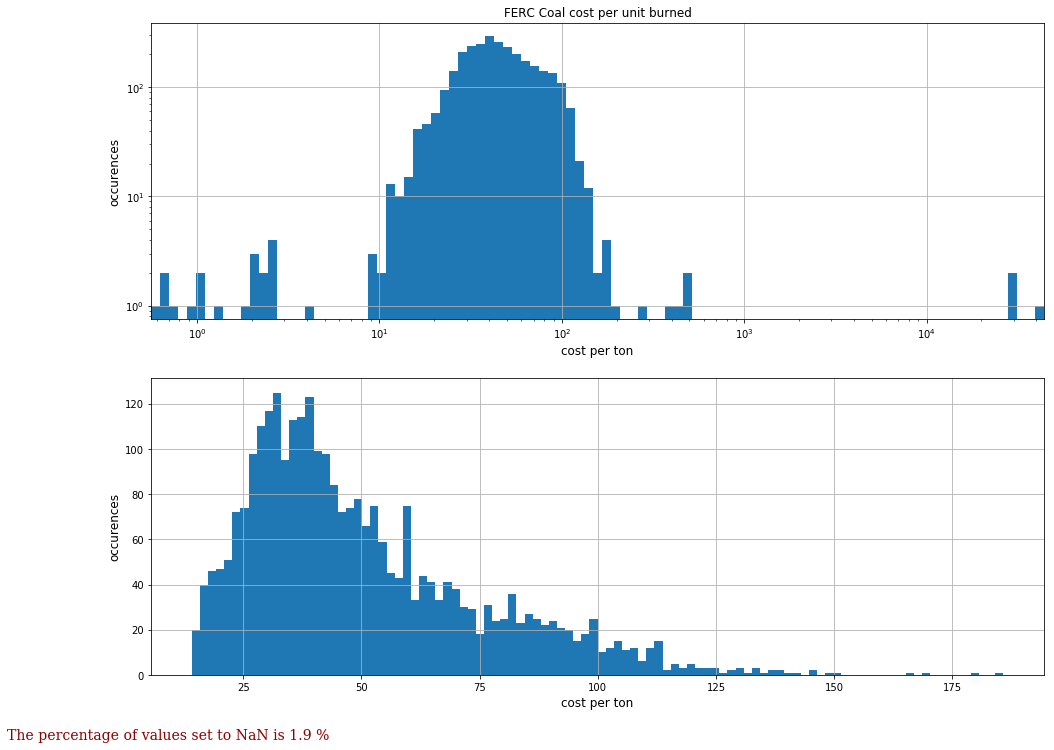

In [254]:
ferc_coal_burned_fixed = fixit(ferc_coal_cost_burned.fuel_cost_per_unit_burned, 14, 190, [1])
showfix(ferc_coal_cost_burned.fuel_cost_per_unit_burned,ferc_coal_burned_fixed, \
        'FERC Coal cost per unit burned','cost per ton','occurences')

As expected, there is great overlap between the two distributions. Given the lag between fuel delivery and fuel consumption, it is not surprising that they are not precisely the same.

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


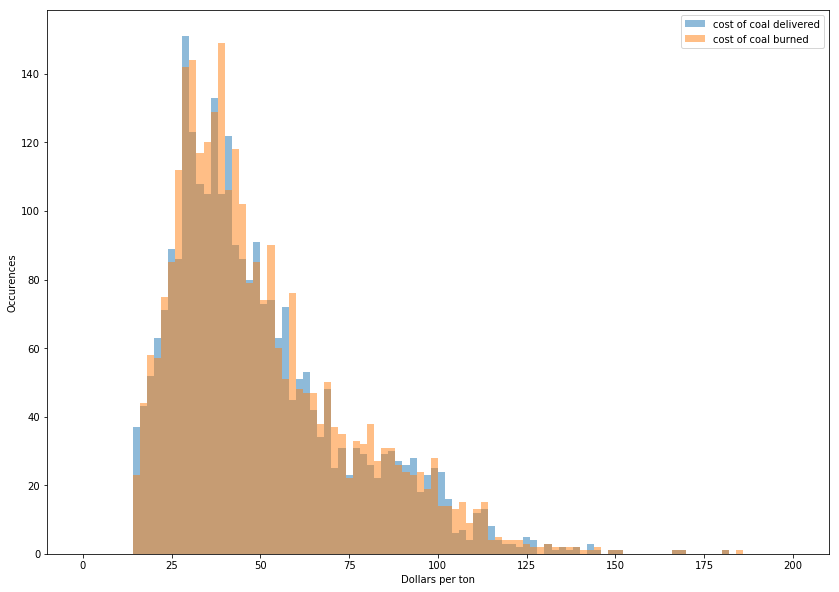

In [269]:
plt.figure(figsize=(14,10))
plt.hist(ferc_delivered_coal,bins=100, range=(0,200),alpha=.5,label='cost of coal delivered')
plt.hist(ferc_coal_burned_fixed,bins=100, range=(0,200),alpha=.5,label='cost of coal burned')
plt.xlabel('Dollars per ton')
plt.ylabel('Occurences')
plt.legend()
plt.show()

### FERC Gas cost per unit burned
Let's take a look at histograms for FERC cost per unit burned for gas. Again, we can rely on the same range of values used for the cost of fuel delivered. We expect that the values will be very similar to the results for cost per unit delivered.

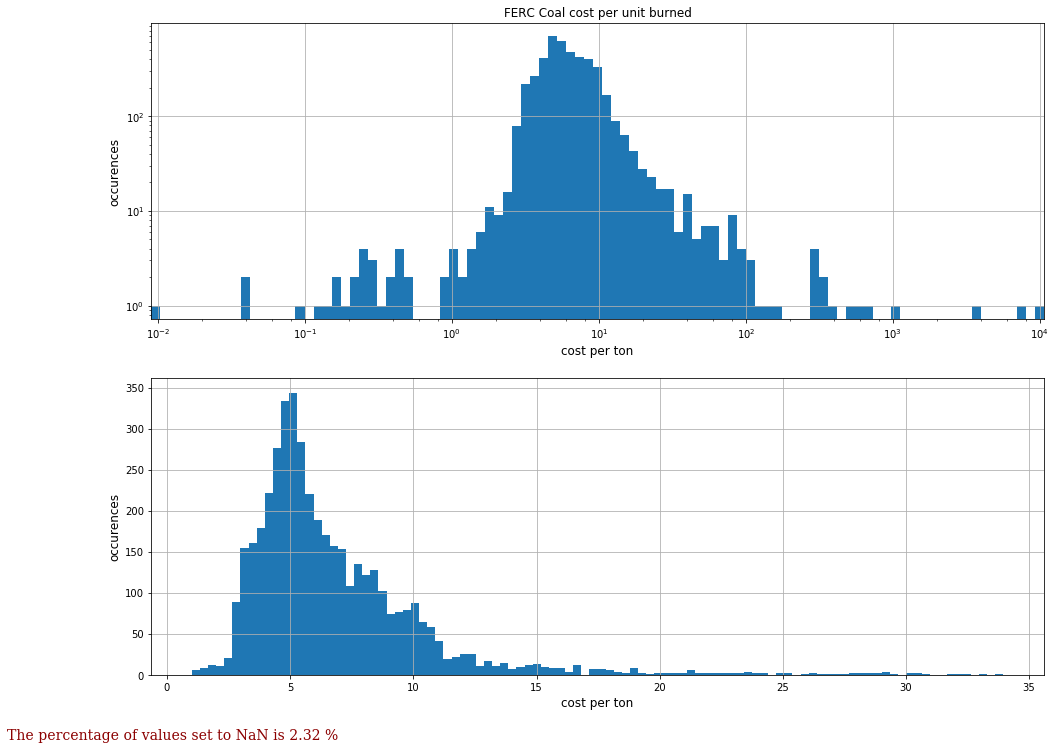

In [270]:
ferc_gas_burned_fixed = fixit(ferc_gas_cost_burned.fuel_cost_per_unit_burned, 1, 35, [1])
showfix(ferc_gas_cost_burned.fuel_cost_per_unit_burned,ferc_gas_burned_fixed, \
        'FERC Coal cost per unit burned','cost per ton','occurences')

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


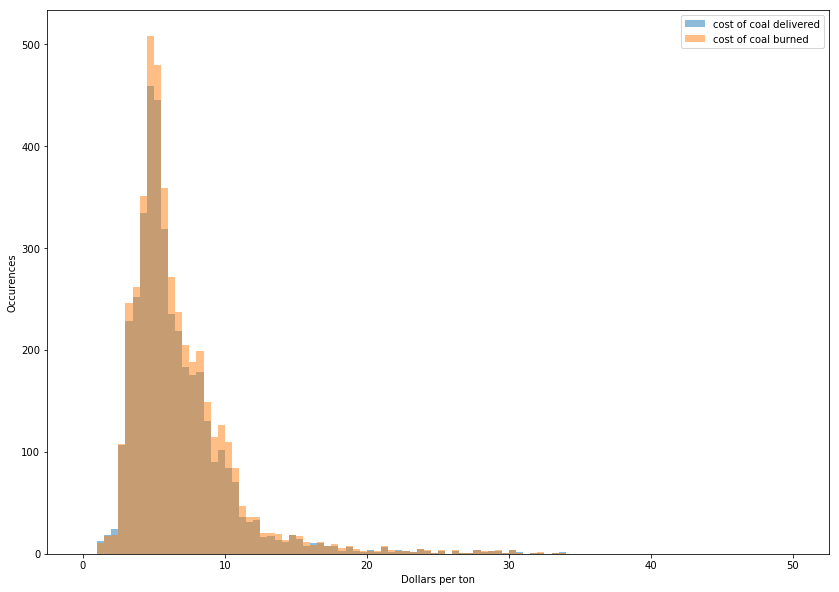

In [278]:
plt.figure(figsize=(14,10))
plt.hist(ferc_delivered_gas,bins=100, range=(0,50),alpha=.5,label='cost of coal delivered')
plt.hist(ferc_gas_burned_fixed,bins=100, range=(0,50),alpha=.5,label='cost of coal burned')
plt.xlabel('Dollars per ton')
plt.ylabel('Occurences')
plt.legend()
plt.show()

Once again, there's considerable overlap between the cost of fuel delivered and the cost of fuel burned.